In [2]:
import pandas as pd
import numpy as np

# 1. Cargar datasets
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_finales.xlsx")

# 2. Separar variables categóricas y continuas según número de valores únicos
umbral_categoricas = 10  # puedes ajustar este número si hace falta
vars_numericas = df_reales.select_dtypes(include=[np.number]).columns.tolist()

# Excluir la variable target si está
if 'target' in vars_numericas:
    vars_numericas.remove('target')

# Clasificación basada en cardinalidad
vars_categoricas = [col for col in vars_numericas if df_reales[col].nunique() <= umbral_categoricas]
vars_continuas = [col for col in vars_numericas if df_reales[col].nunique() > umbral_categoricas]

print("✅ Variables categóricas detectadas:", vars_categoricas)
print("✅ Variables continuas detectadas:", vars_continuas)

# 3. Calcular percentiles P1 y P99 en los datos reales solo para continuas
percentiles = {
    var: {
        'p1': np.percentile(df_reales[var], 1),
        'p99': np.percentile(df_reales[var], 99)
    }
    for var in vars_continuas
}

# 4. Aplicar recorte a los datos sintéticos
df_sinteticos_recortados = df_sinteticos.copy()
for var in vars_continuas:
    if var in df_sinteticos.columns:
        p1 = percentiles[var]['p1']
        p99 = percentiles[var]['p99']
        df_sinteticos_recortados[var] = df_sinteticos[var].clip(lower=p1, upper=p99)

# 5. Guardar el resultado
df_sinteticos_recortados.to_excel("datos_sinteticos_recortados.xlsx", index=False)
print("✅ Archivo guardado como 'datos_sinteticos_recortados.xlsx'")


✅ Variables categóricas detectadas: ['Sexo', 'Etnia', 'Hábito tabáquico', 'Consumo de alcohol', 'Consumo de cocaína', 'HTA', 'DM', 'DL', 'Enf cardiovascular', 'Patología respiratoria', 'Otras EAS', 'ERC', 'Neoplasias', 'Hipotiroidismo', 'Sospecha fármaco', 'Infecciones previas', 'Criterios ACR/EULAR2022', 'Generales', 'Musculoesqueléticas', 'Cutáneas', 'Mucosas', 'Oculares', 'ORL', 'Torácicas', 'Cardiovasculares', 'Abdominales', 'Renales', 'Sistema nervioso', 'Hematuria', 'Proteinuria', 'pANCA', 'pANCA IFI', 'cANCA', 'cANCA IFI', 'MPO si/no', 'PR3 si/no', 'Bx renal', 'FFS', 'GC ind', 'Bolos GC', 'CFM ind', 'MTX ind', 'AZA ind', 'MMF ind', 'Aféresis ind', 'IVIG ind', 'a-CD20 ind', 'anti-IL5 ind', 'Avacopan ind', 'TMP/SMZ ind', 'GC mant', 'MTX mant', 'AZA mant', 'MMF mant', 'a-CD20 mant', 'a-IL5 mant', 'Avacopan mant', 'Respuesta 6m', 'Respuesta 12 m', 'Respuesta 24m', 'Respuesta UV', 'Remisión 6m', 'Remisión 12 m', 'Remisión 24 m', 'Remisión UV', 'Recaída', 'Nª recaída', 'IRC', 'ERCA', 

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\2722514307.py:38: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sinteticos_recortados[var] = df_sinteticos[var].clip(lower=p1, upper=p99)


✅ Archivo guardado como 'datos_sinteticos_recortados.xlsx'


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import chi2
from scipy.spatial.distance import mahalanobis

# Cargar datos
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_recortados.xlsx")  # ya recortados

# Detectar variables continuas por número de valores únicos
umbral_categoricas = 10
vars_numericas = df_reales.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in vars_numericas:
    vars_numericas.remove('target')

vars_continuas = [col for col in vars_numericas if df_reales[col].nunique() > umbral_categoricas]
variables_comunes = [col for col in vars_continuas if col in df_sinteticos.columns and col in df_reales.columns]

# Filtrar datos
X_real = df_reales[variables_comunes].dropna()
X_sint = df_sinteticos[variables_comunes].dropna()

# Calcular media y matriz de covarianza del conjunto real
mu = X_real.mean().values
cov = np.cov(X_real.values, rowvar=False)
inv_covmat = np.linalg.inv(cov)

# Calcular distancia de Mahalanobis para cada registro sintético
dist_maha = np.array([mahalanobis(x, mu, inv_covmat) for x in X_sint.values])

# Umbral de corte para 99% de confianza con k variables
k = len(variables_comunes)
threshold = np.sqrt(chi2.ppf(0.99, df=k))

# Filtrar sintéticos "cercanos"
X_sint_filtrado = X_sint[dist_maha <= threshold]

# Recuperar filas originales filtradas (para mantener columnas categóricas)
df_sinteticos_filtrados = df_sinteticos.loc[X_sint_filtrado.index]

# Guardar resultado
df_sinteticos_filtrados.to_excel("datos_sinteticos_mahalanobis.xlsx", index=False)
print(f"✅ Filtrado por Mahalanobis completado. Registros finales: {len(df_sinteticos_filtrados)}")


✅ Filtrado por Mahalanobis completado. Registros finales: 500


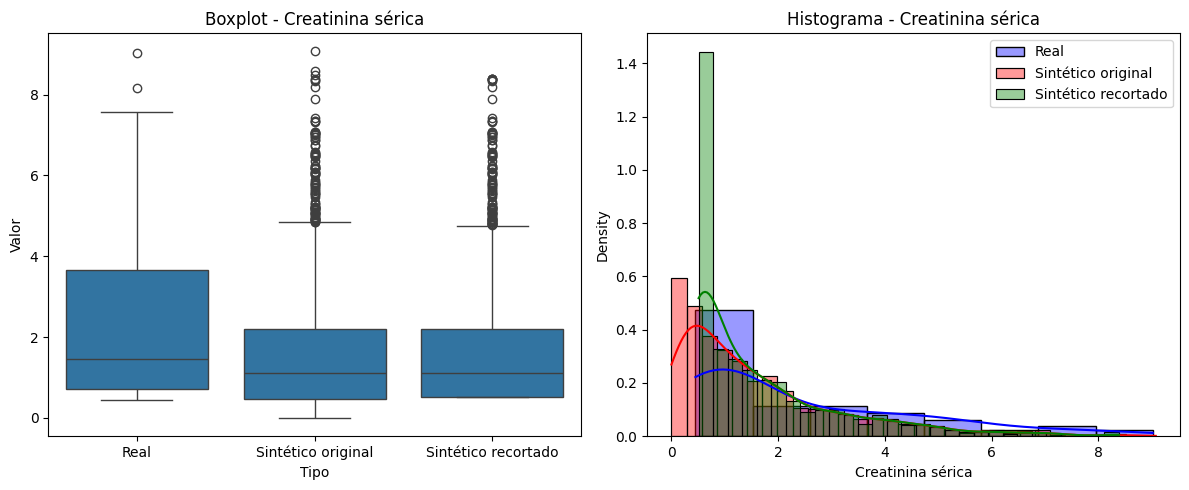

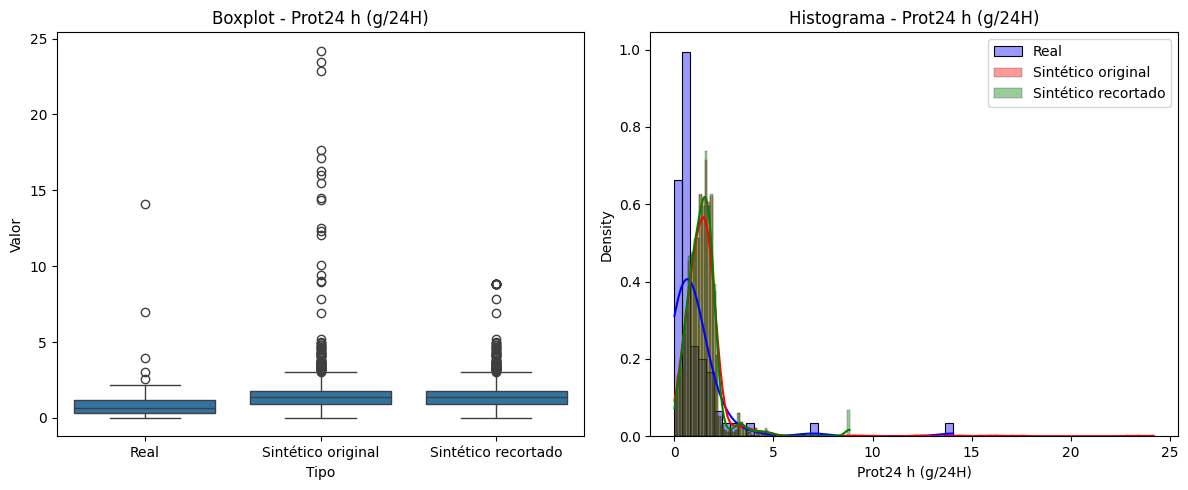

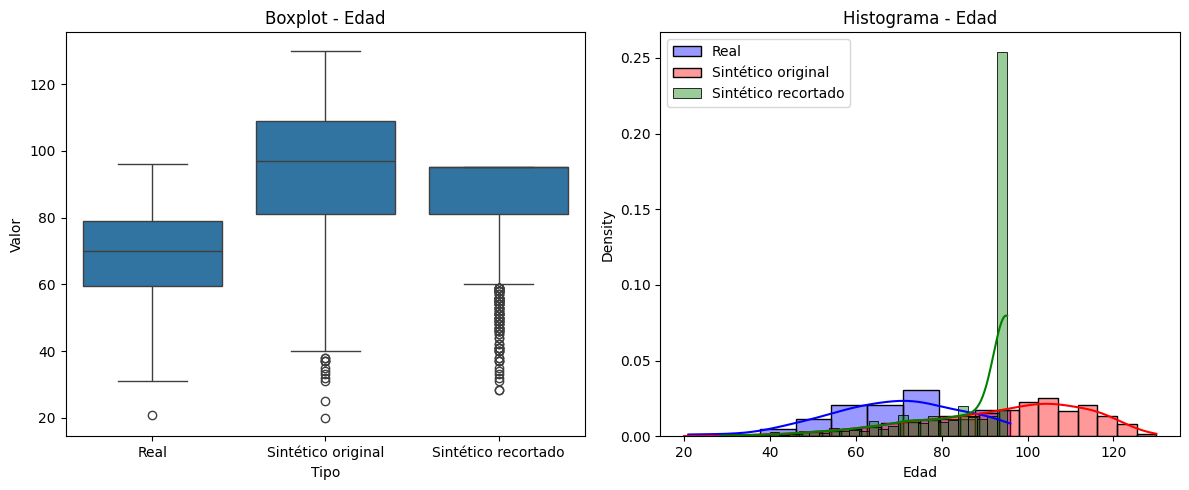

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_finales.xlsx")
df_recortados = pd.read_excel("datos_sinteticos_recortados.xlsx")

# Elegir variables representativas (ajusta si quieres otras)
variables_a_graficar = ["Creatinina sérica", "Prot24 h (g/24H)", "Edad"]

# Crear gráficos comparativos
for var in variables_a_graficar:
    plt.figure(figsize=(12, 5))

    # --- Boxplot ---
    plt.subplot(1, 2, 1)
    datos_box = pd.DataFrame({
        "Valor": pd.concat([
            df_reales[var],
            df_sinteticos[var],
            df_recortados[var]
        ], ignore_index=True),
        "Tipo": (["Real"] * len(df_reales)
                 + ["Sintético original"] * len(df_sinteticos)
                 + ["Sintético recortado"] * len(df_recortados))
    })
    sns.boxplot(data=datos_box, x="Tipo", y="Valor")
    plt.title(f"Boxplot - {var}")

    # --- Histograma superpuesto ---
    plt.subplot(1, 2, 2)
    sns.histplot(df_reales[var], color="blue", label="Real", kde=True, stat="density", alpha=0.4)
    sns.histplot(df_sinteticos[var], color="red", label="Sintético original", kde=True, stat="density", alpha=0.4)
    sns.histplot(df_recortados[var], color="green", label="Sintético recortado", kde=True, stat="density", alpha=0.4)
    plt.title(f"Histograma - {var}")
    plt.legend()

    plt.tight_layout()
    plt.show()


C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\2746072746.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")
C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\2746072746.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")
C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\2746072746.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


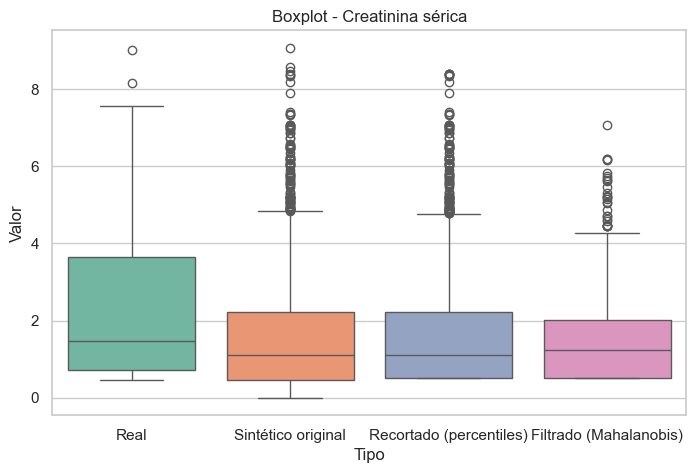

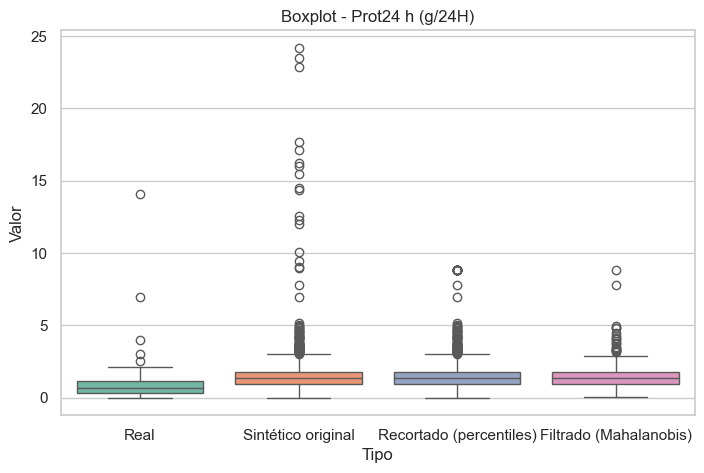

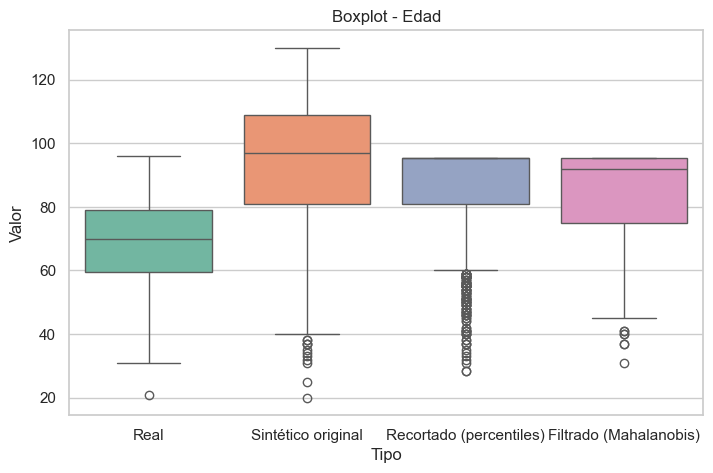

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datasets
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_finales.xlsx")
df_recortados = pd.read_excel("datos_sinteticos_recortados.xlsx")
df_mahalanobis = pd.read_excel("datos_sinteticos_mahalanobis.xlsx")

# Variables a comparar (puedes cambiar estas)
variables_a_graficar = [
    "Creatinina sérica",
    "Prot24 h (g/24H)",
    "Edad"
]

sns.set(style="whitegrid")

for var in variables_a_graficar:
    plt.figure(figsize=(18, 5))
    
    # --- Boxplot ---
    plt.subplot(1, 2, 1)
    datos_box = pd.DataFrame({
        "Valor": pd.concat([
            df_reales[var],
            df_sinteticos[var],
            df_recortados[var],
            df_mahalanobis[var]
        ], ignore_index=True),
        "Tipo": (
            ["Real"] * len(df_reales)
            + ["Sintético original"] * len(df_sinteticos)
            + ["Recortado (percentiles)"] * len(df_recortados)
            + ["Filtrado (Mahalanobis)"] * len(df_mahalanobis)
        )
    })
    sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")
    plt.title(f"Boxplot - {var}")


C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


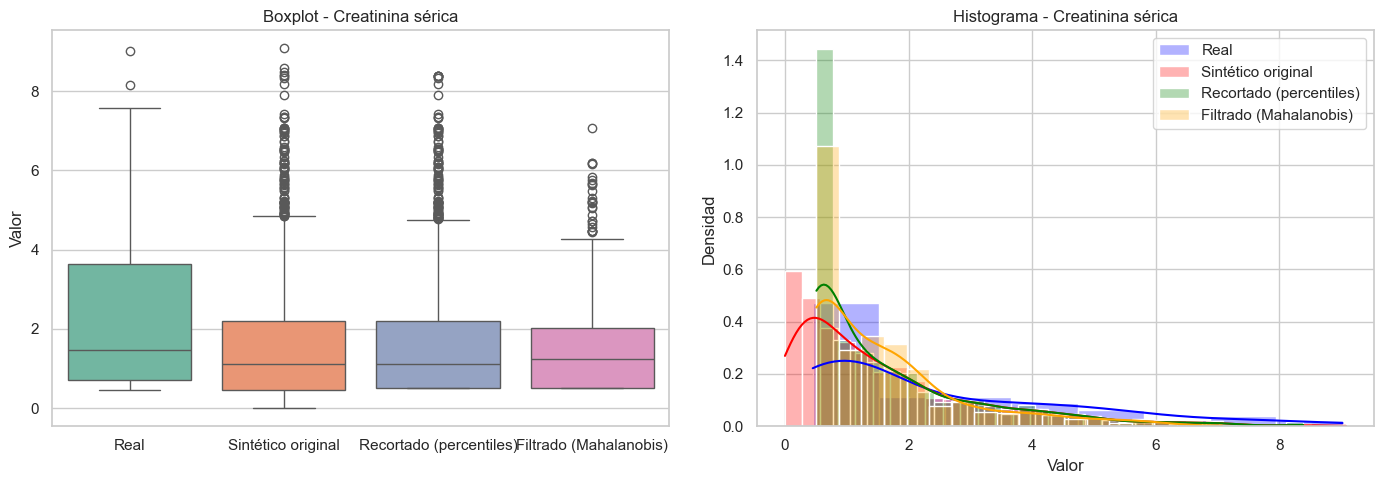

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


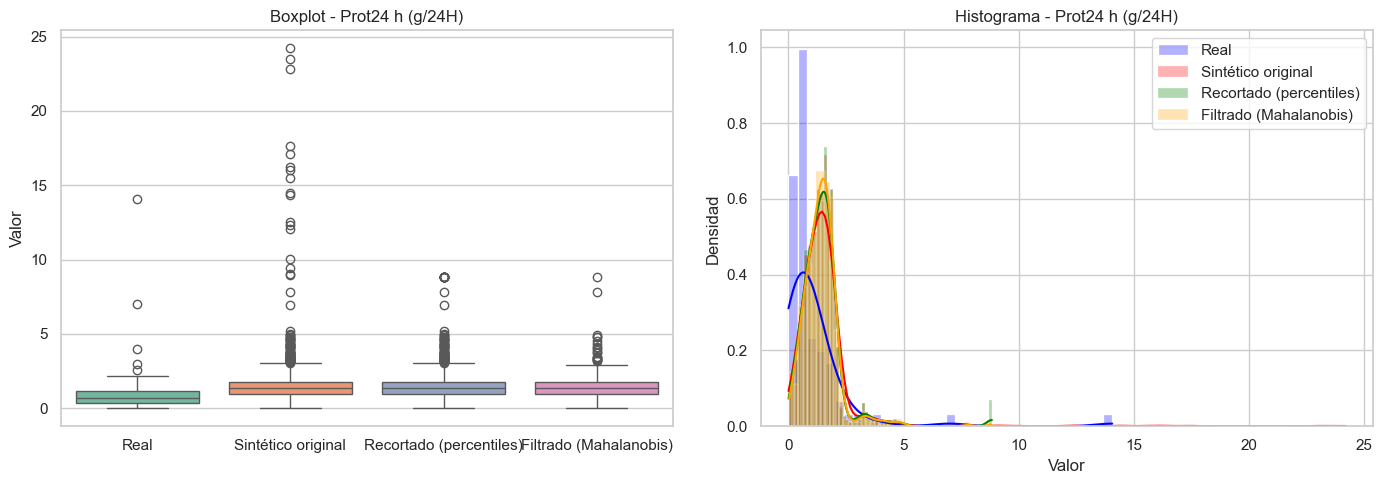

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


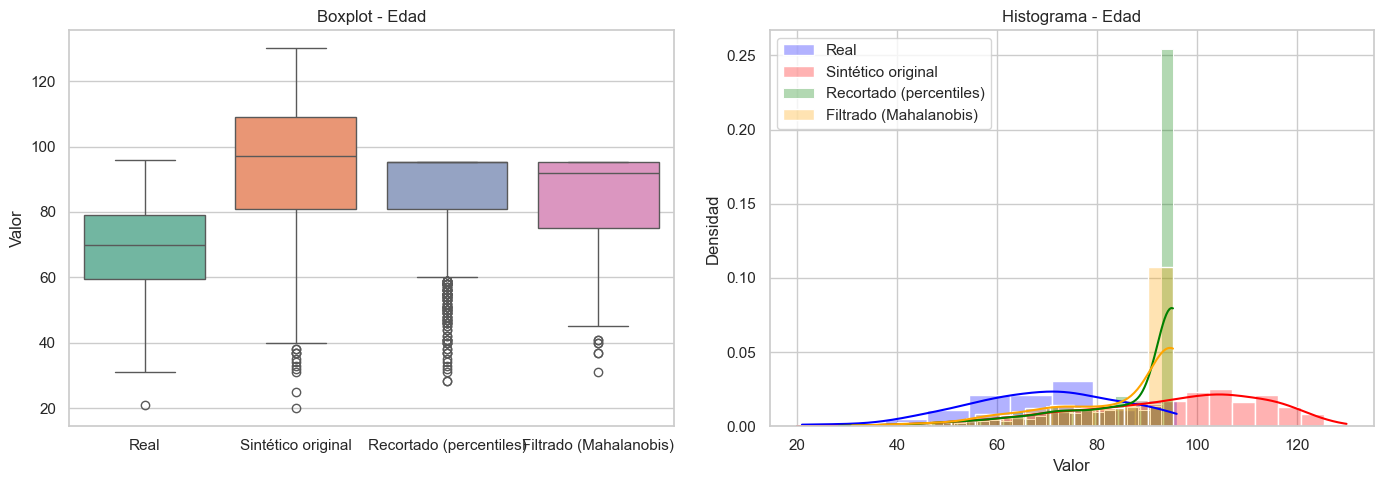

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


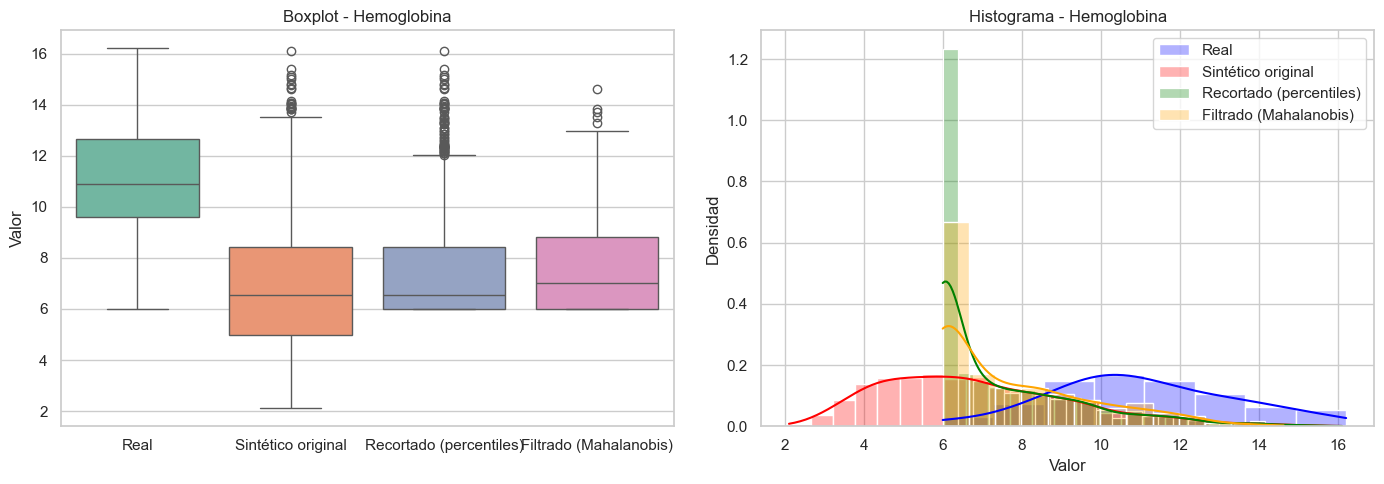

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


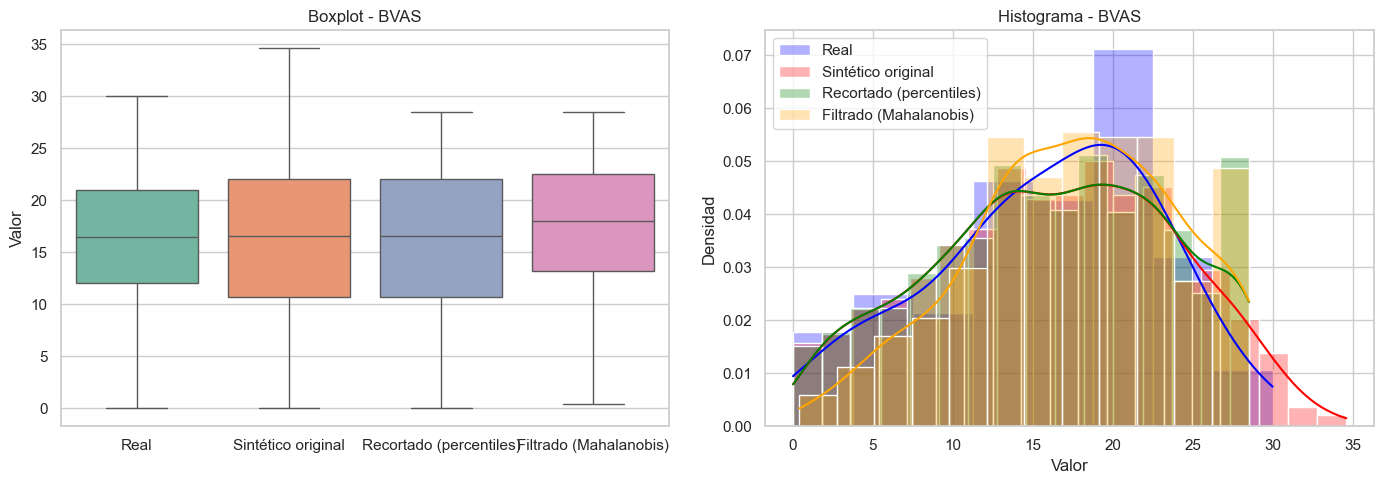

C:\Users\ut07137\AppData\Local\Temp\ipykernel_27152\3673498533.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")


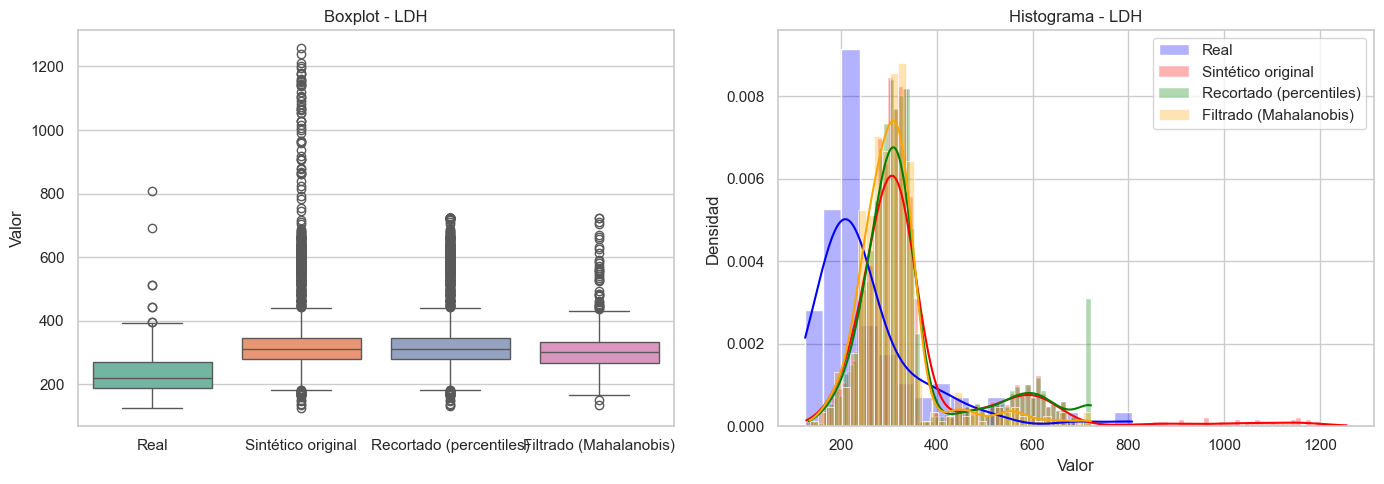

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datasets
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_finales.xlsx")
df_recortados = pd.read_excel("datos_sinteticos_recortados.xlsx")
df_mahalanobis = pd.read_excel("datos_sinteticos_mahalanobis.xlsx")

# Variables a graficar
variables_a_graficar = [
    "Creatinina sérica",
    "Prot24 h (g/24H)",
    "Edad",
    "Hemoglobina",
    "BVAS",
    "LDH"
]

sns.set(style="whitegrid")

for var in variables_a_graficar:
    plt.figure(figsize=(14, 5))
    
    # --- Boxplot ---
    plt.subplot(1, 2, 1)
    datos_box = pd.DataFrame({
        "Valor": pd.concat([
            df_reales[var],
            df_sinteticos[var],
            df_recortados[var],
            df_mahalanobis[var]
        ], ignore_index=True),
        "Tipo": (
            ["Real"] * len(df_reales)
            + ["Sintético original"] * len(df_sinteticos)
            + ["Recortado (percentiles)"] * len(df_recortados)
            + ["Filtrado (Mahalanobis)"] * len(df_mahalanobis)
        )
    })
    sns.boxplot(data=datos_box, x="Tipo", y="Valor", palette="Set2")
    plt.title(f"Boxplot - {var}")
    plt.xlabel("")
    plt.ylabel("Valor")

    # --- Histograma superpuesto ---
    plt.subplot(1, 2, 2)
    sns.histplot(df_reales[var], color="blue", label="Real", kde=True, stat="density", alpha=0.3)
    sns.histplot(df_sinteticos[var], color="red", label="Sintético original", kde=True, stat="density", alpha=0.3)
    sns.histplot(df_recortados[var], color="green", label="Recortado (percentiles)", kde=True, stat="density", alpha=0.3)
    sns.histplot(df_mahalanobis[var], color="orange", label="Filtrado (Mahalanobis)", kde=True, stat="density", alpha=0.3)
    plt.title(f"Histograma - {var}")
    plt.xlabel("Valor")
    plt.ylabel("Densidad")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [9]:
import pandas as pd
from scipy.stats import ks_2samp

# Cargar datasets
df_reales = pd.read_excel("dataset_reales_imputados.xlsx")
df_sinteticos = pd.read_excel("datos_sinteticos_finales.xlsx")
df_recortados = pd.read_excel("datos_sinteticos_recortados.xlsx")
df_mahalanobis = pd.read_excel("datos_sinteticos_mahalanobis.xlsx")

# Variables seleccionadas para comparar
variables = [
    "Creatinina sérica",
    "Prot24 h (g/24H)",
    "Edad",
    "Hemoglobina",
    "BVAS",
    "LDH"
]

# Almacenar resultados
resultados = []

for var in variables:
    for label, df in [
        ("Sintético original", df_sinteticos),
        ("Recortado (percentiles)", df_recortados),
        ("Filtrado (Mahalanobis)", df_mahalanobis)
    ]:
        ks_stat, p_value = ks_2samp(df_reales[var].dropna(), df[var].dropna())
        resultados.append({
            "Variable": var,
            "Comparación": label,
            "KS_stat": ks_stat,
            "p_value": p_value,
            "¿Similares?": "Similares" if p_value > 0.05 else "Diferentes"
        })

# Convertir a DataFrame para exportar o visualizar
df_resultados = pd.DataFrame(resultados)

# # Guardar en Excel si lo deseas
# df_resultados.to_excel("resultados_KS_test.xlsx", index=False)

# Mostrar resultado
print(df_resultados)


             Variable              Comparación   KS_stat       p_value  \
0   Creatinina sérica       Sintético original  0.276052  2.437522e-05   
1   Creatinina sérica  Recortado (percentiles)  0.276052  2.437522e-05   
2   Creatinina sérica   Filtrado (Mahalanobis)  0.248667  4.951519e-04   
3    Prot24 h (g/24H)       Sintético original  0.515345  3.102534e-18   
4    Prot24 h (g/24H)  Recortado (percentiles)  0.515345  3.102534e-18   
5    Prot24 h (g/24H)   Filtrado (Mahalanobis)  0.523333  5.263634e-17   
6                Edad       Sintético original  0.537952  5.918970e-20   
7                Edad  Recortado (percentiles)  0.537952  5.918970e-20   
8                Edad   Filtrado (Mahalanobis)  0.461333  3.881757e-13   
9         Hemoglobina       Sintético original  0.648380  6.595890e-30   
10        Hemoglobina  Recortado (percentiles)  0.648380  6.595890e-30   
11        Hemoglobina   Filtrado (Mahalanobis)  0.612000  1.128822e-23   
12               BVAS       Sintético 

In [10]:
import pandas as pd

# Cargar datasets
df_real = pd.read_excel("dataset_reales_imputados.xlsx")
df_sint = pd.read_excel("datos_sinteticos_mahalanobis.xlsx")  # puedes usar el que desees

# Identificar variables categóricas por número de valores únicos
umbral_categoricas = 10
vars_numericas = df_real.select_dtypes(include=["int", "float"]).columns
vars_categoricas = [col for col in vars_numericas if df_real[col].nunique() <= umbral_categoricas]

# Comparar proporciones para cada variable categórica
for col in vars_categoricas:
    print(f"\n🔍 Variable categórica: {col}")

    print("→ Distribución REAL:")
    print(df_real[col].value_counts(normalize=True).sort_index())

    print("→ Distribución SINTÉTICA:")
    print(df_sint[col].value_counts(normalize=True).sort_index())



🔍 Variable categórica: Sexo
→ Distribución REAL:
Sexo
0    0.413333
1    0.586667
Name: proportion, dtype: float64
→ Distribución SINTÉTICA:
Sexo
0    0.552
1    0.448
Name: proportion, dtype: float64

🔍 Variable categórica: Etnia
→ Distribución REAL:
Etnia
1    0.866667
2    0.026667
3    0.080000
4    0.026667
Name: proportion, dtype: float64
→ Distribución SINTÉTICA:
Etnia
1    0.916
2    0.036
3    0.036
4    0.012
Name: proportion, dtype: float64

🔍 Variable categórica: Hábito tabáquico
→ Distribución REAL:
Hábito tabáquico
0    0.56
1    0.44
Name: proportion, dtype: float64
→ Distribución SINTÉTICA:
Hábito tabáquico
0    0.608
1    0.392
Name: proportion, dtype: float64

🔍 Variable categórica: Consumo de alcohol
→ Distribución REAL:
Consumo de alcohol
0    0.866667
1    0.133333
Name: proportion, dtype: float64
→ Distribución SINTÉTICA:
Consumo de alcohol
0    0.942
1    0.058
Name: proportion, dtype: float64

🔍 Variable categórica: Consumo de cocaína
→ Distribución REAL:
Consu

In [11]:
import pandas as pd
from itertools import combinations

# Cargar datasets
df_real = pd.read_excel("dataset_reales_imputados.xlsx")
df_sint = pd.read_excel("datos_sinteticos_mahalanobis.xlsx")  # o el que estés analizando

# Detectar variables categóricas por número de valores únicos
umbral_categoricas = 10
vars_numericas = df_real.select_dtypes(include=["int", "float"]).columns.tolist()
vars_categoricas = [col for col in vars_numericas if df_real[col].nunique() <= umbral_categoricas]

# Lista para guardar resultados
combinaciones_nuevas = []

# Comprobar todas las combinaciones de 2 variables categóricas
for var1, var2 in combinations(vars_categoricas, 2):
    real_pairs = set(tuple(x) for x in df_real[[var1, var2]].dropna().values)
    sint_pairs = set(tuple(x) for x in df_sint[[var1, var2]].dropna().values)
    nuevas = sint_pairs - real_pairs

    for comb in nuevas:
        count = len(df_sint[(df_sint[var1] == comb[0]) & (df_sint[var2] == comb[1])])
        combinaciones_nuevas.append({
            "Variable 1": var1,
            "Variable 2": var2,
            "Valor 1": comb[0],
            "Valor 2": comb[1],
            "Nº registros sintéticos": count
        })

# Convertir a DataFrame y ordenar por número de registros
df_combinaciones = pd.DataFrame(combinaciones_nuevas)
df_combinaciones = df_combinaciones.sort_values(by="Nº registros sintéticos", ascending=False)

# Guardar o mostrar
df_combinaciones.to_excel("combinaciones_bivariadas_nuevas.xlsx", index=False)
print(df_combinaciones.head(10))


     Variable 1           Variable 2  Valor 1  Valor 2  \
1418    Recaída           Nª recaída        1        0   
1021   Bx renal  Resultado renal cat        0        1   
627     Renales          Proteinuria        0        1   
1283   MTX mant               target        1        1   
675   Hematuria  Resultado renal cat        0        1   
1032        FFS             MTX mant        1        1   
1485        IRC                 ERCA        0        1   
698       pANCA            pANCA IFI        0       80   
1015   Bx renal             MTX mant        1        1   
287          DL             MTX mant        1        1   

      Nº registros sintéticos  
1418                      195  
1021                      112  
627                       101  
1283                       97  
675                        95  
1032                       90  
1485                       90  
698                        90  
1015                       79  
287                        78  
